In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dates.txt',sep=";", header=None, names=["mail_route","mail_date"])

##### Now we can extract the user, mail folder, year, hour, day of the week, and if the day was a holiday 

In [3]:

def get_user(x):
    t = x[(x.find("dir/")+4):]
    return t[:t.find("/")]

def get_mail_folder(x):
    t = x[(x.find("dir/")+4):]
    t2 = t[(t.find("/")+1):]
    return t2[:t2.find("/")]

def get_date(x):
    return pd.to_datetime(x.split("Date:")[1])

def get_dayweek(x):
    return x.dayofweek

def get_year(x):
    return x.year

def get_hour(x):
    return x.hour

def get_month(x):
    return x.month


In [4]:
kwargs = {
    "user_name" : df.mail_route.apply(get_user),
    "folder_name" : df.mail_route.apply(get_mail_folder),
    "date_time" : df.mail_date.apply(get_date),
}

df = df.assign(**kwargs)

In [5]:

cal = calendar()
holidays = cal.holidays(start=df.date_time.min(), end=df.date_time.max())

kwargs = {
    "year" : df.date_time.apply(get_year),
    "hour" : df.date_time.apply(get_hour),
    "day_week" : df.date_time.apply(get_dayweek),
    "month" : df.date_time.apply(get_month),
    "holiday" : df['date_time'].isin(holidays)
}
df = df.assign(**kwargs)    

### The first think we realize is: There are emails from he future
- https://www.nytimes.com/2006/01/18/business/worldbusiness/timeline-a-chronology-of-enron-corp.html

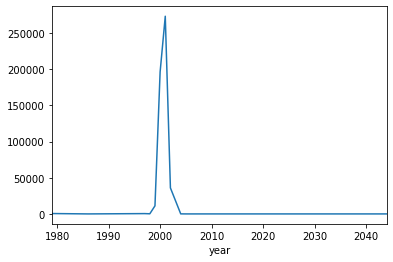

In [6]:
df.groupby("year").date_time.count().plot()

##### we will assign a first red flag to those mails from the future

In [7]:
df = df.assign(red_flag_year=np.where((df.year>2002), 1, 0))

##### also another red flag for those mails sent on holidays ( fraudsters tend to work even on holidays )

In [8]:
df = df.assign(red_flag_holidays=np.where(df.holiday ==1 , 1, 0))

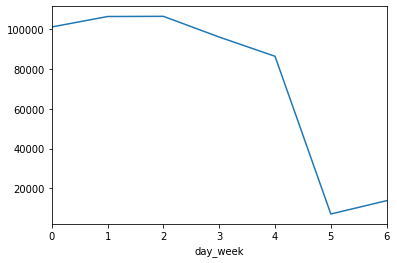

In [9]:
df.groupby("day_week").hour.count().plot()

##### another red flag for mails sent on weekend

In [10]:
df = df.assign(red_flag_weekend= np.where((df.day_week==5)|(df.day_week==6), 1, 0))

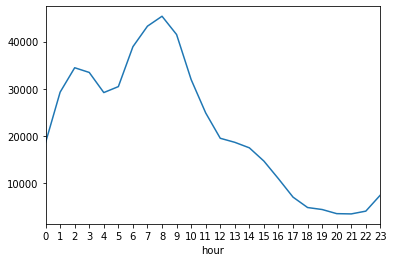

In [11]:
df.groupby("hour").hour.count().plot()
plt.xticks(range(24));

##### looking at the hours of the sent emails by year, we can see that the "night" emails were much  more usual in the years previous to the scandal

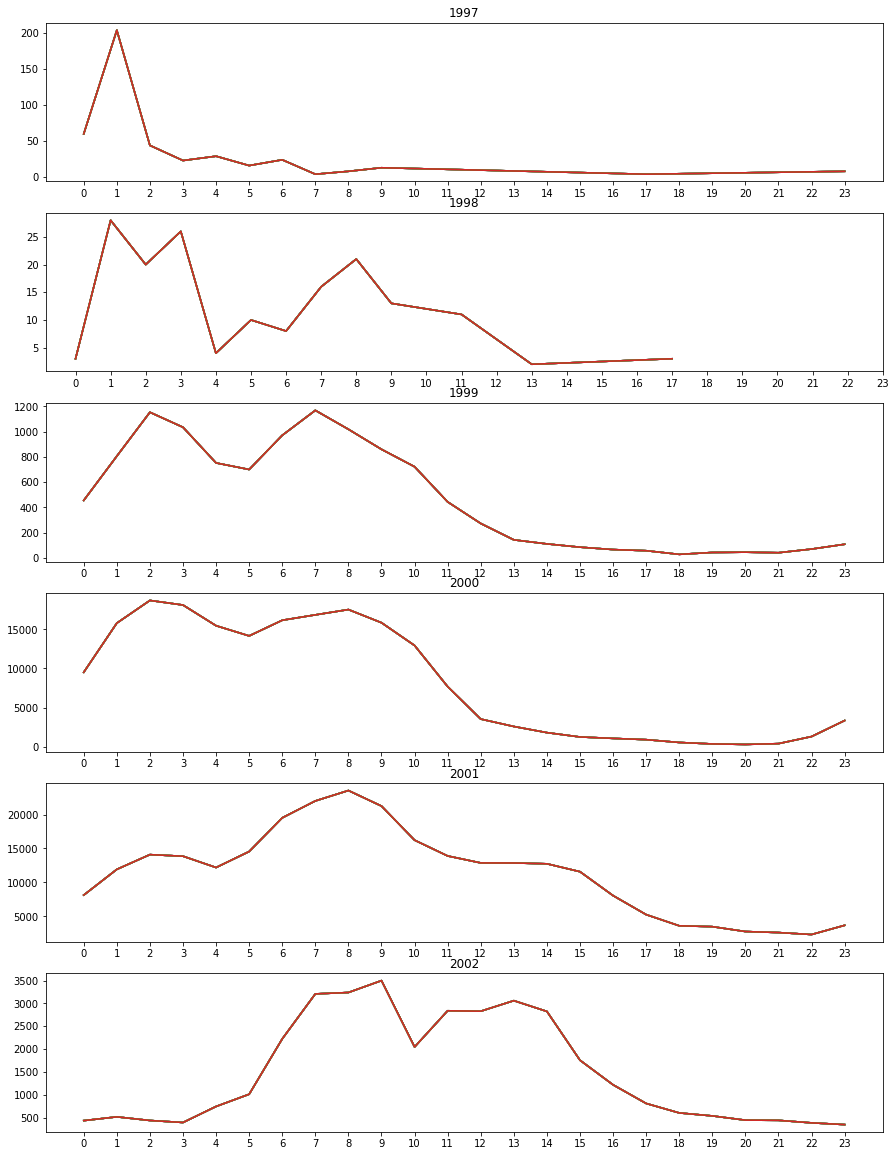

In [57]:
ncols = 6
fig, ax = plt.subplots(ncols,figsize=(15,7),gridspec_kw=dict(bottom=-1.2, top=1))
y = 1997
for c in range(ncols): 
    ax[c].plot(df[df.year==y].groupby("hour").count())
    ax[c].set_title(y)
    y += 1
    ax[c].set_xticks(range(24))

##### yet another red flag for mails sent out of normal working hours

In [13]:
df = df.assign(red_flag_working_hours=np.where((df.hour>18)|(df.hour<5), 1,0))

In [14]:
red_flags = [i for i in df.columns if i.find("red_flag")!=-1]

In [15]:
red_flags

['red_flag_year',
 'red_flag_holidays',
 'red_flag_weekend',
 'red_flag_working_hours']

##### now we have the count of the red flags

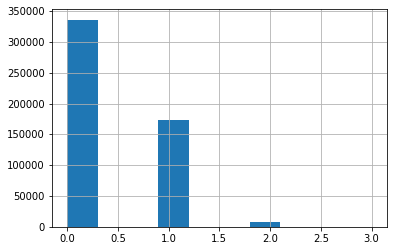

In [16]:
df[red_flags].sum(axis=1).sort_values(ascending=False).hist()

In [17]:
df = df.assign(red_flag_count=df[red_flags].sum(axis=1))

##### we can now plot the distribution in time of our flags

Text(0.5, 1.0, '% of red flags of the total of mails')

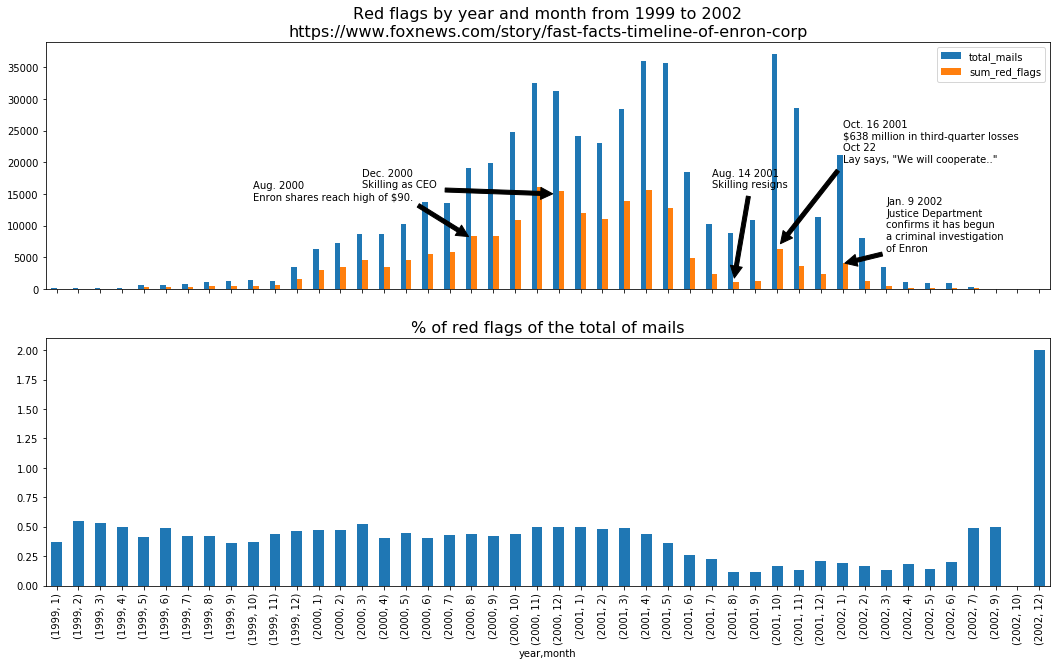

In [58]:
def annotate(plt):
    plt.annotate('Aug. 2000\nEnron shares reach high of $90.', xy=(19, 8000), xytext=(9, 14000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
    plt.annotate('Dec. 2000\nSkilling as CEO', xy=(23, 15000), xytext=(14, 16000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
    plt.annotate('Aug. 14 2001\nSkilling resigns', xy=(31, 1000), xytext=(30, 16000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
    plt.annotate('Oct. 16 2001\n$638 million in third-quarter losses\nOct 22\nLay says, "We will cooperate.."', xy=(33, 6500), xytext=(36, 20000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
    plt.annotate('Jan. 9 2002\nJustice Department\nconfirms it has begun\na criminal investigation \nof Enron', xy=(36, 4000), xytext=(38, 6000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )    

fig, ax= plt.subplots(2,1, sharex=True)    
    
dfrf = pd.concat((df[(df.year>1998)&(df.year<2003)].groupby(["year","month"]).red_flag_count.count(),    
                  df[(df.year>1998)&(df.year<2003)].groupby(["year","month"]).red_flag_count.sum()), axis=1)

dfrf.columns=["total_mails","sum_red_flags"]
dfrf.plot(kind="bar", figsize=(18,10), ax=ax[0])  
    
    
ax[0].set_title("Red flags by year and month from 1999 to 2002\nhttps://www.foxnews.com/story/fast-facts-timeline-of-enron-corp", fontsize=16)
annotate(ax[0])


( dfrf["sum_red_flags"] / dfrf["total_mails"]).plot(kind="bar", figsize=(18,10), ax=ax[1])
ax[1].set_title("% of red flags of the total of mails", fontsize=16)

#### Such a coincidence! In Jan 2002, as the Justice Department confirms its investigation, the CEO deleted a not inconsiderable amount of emails

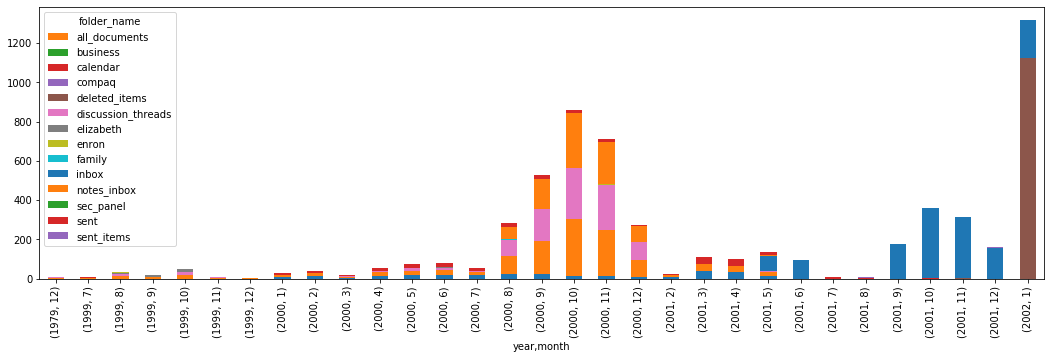

In [81]:
df[(df.user_name=="lay-k")].groupby(["year","month","folder_name"]).hour.count().unstack().plot(kind="bar", stacked=True, figsize=(18,5))

## Conclusion:
- This is a very basic analysis, but only looking at the dates can show some tips about how things are going inside the company.
- As all our flags are not decisive clues, they can be some kind of compass to find the direction we have to follow in the investigation.
- Fraud prevention systems must be implementated in order to avoid more cases like these.